# Explore levers

If fixed default uncertainties, explore the outcomes at five different locations under different levers.

*Upstream - A1 (Doesburg), A2 (Contenoever), A3 (Zutphen), A4 (Gorssel), A5 (Deventer) - Downstream*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator, 
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\georg\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id

In [8]:
for uncertainties in dike_model.uncertainties:
    print(repr(uncertainties))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [9]:
default_uncertainties = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                         'discount rate': 3.5,
                         'ID flood wave shape': 4}

ref_uncertainties = {}

for key in dike_model.uncertainties:
    if '_' in key.name:
        _, s = key.name.split('_')
    else:
        s, _ = key.name.rsplit(' ', 1)
    ref_uncertainties.update({key.name: default_uncertainties[s]})
ref_uncertainties = Scenario('reference', **ref_uncertainties)

In [10]:
n_scenarios = 1000

espilon = [1e2, 1e2, 1]

convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[5e6, 2e9, 1]),
                       EpsilonProgress()]

In [11]:
%%time
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.optimize(nfe=n_scenarios, 
                                 searchover='levers',
                                 epsilons=espilon,
                                 convergence=convergence_metrics,
                                 reference=ref_uncertainties)

save_results(results, "scenario0 1000runs_experiments.tar.gz")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 498/1000 nfe
[MainProcess/INFO] generation 10: 997/1000 nfe
[MainProcess/INFO] optimization completed, found 5 solutions
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\scenario0 1000runs_experiments.tar.gz


Wall time: 7min 56s


## Analysis

In [3]:
results = load_results(".\scenario0 1000runs_experiments.tar.gz")

outcomes, convergence = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\final assignment\scenario0 1000runs_experiments.tar.gz


In [4]:
outcomes

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Total Investment Costs,Expected Number of Deaths
0,0,0,0,0,0,0,0,0,0,0,...,7,4,5,2,7,4,2,1.579645e+07,3.958391e+08,0.013909
1,0,0,0,0,0,0,0,0,0,0,...,4,8,9,5,6,6,2,0.000000e+00,4.137517e+08,0.000000
2,0,0,0,0,0,0,0,0,1,0,...,7,0,9,1,5,4,2,5.220908e+07,3.119361e+08,0.006221
3,0,0,0,0,0,0,1,1,1,0,...,9,7,5,0,6,0,6,2.445381e+07,3.477181e+08,0.002611
4,0,0,0,0,0,0,1,0,0,0,...,9,5,5,5,5,3,2,7.785843e+05,4.044091e+08,0.000338


Text(0.5,0,'number of function evaluations')

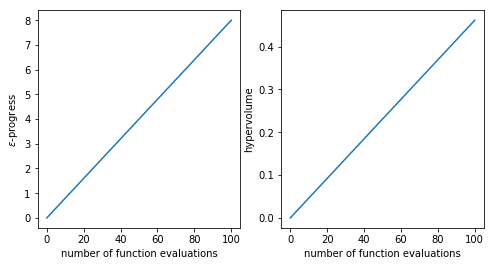

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')

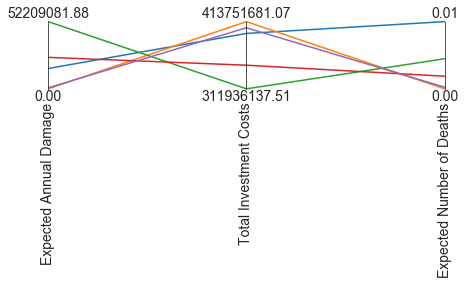

In [15]:
data = outcomes.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)